In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import keras
from keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model,load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import cv2

In [3]:
covid_path = '/content/gdrive/MyDrive/covid-19/chest_xray/train/COVID'
noncovid_path= '/content/gdrive/MyDrive/covid-19/chest_xray/test/normal'

In [4]:
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path +'/*')
covid_labels = []
noncovid_labels = []
covid_images=[]
noncovid_images=[]

In [5]:
for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')

In [6]:
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')


In [7]:
covid_images = np.array(covid_images) / 255
noncovid_images =np.array(noncovid_images) / 255

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [9]:
covid_x_train, covid_x_test, covid_y_train, covid_y_test =train_test_split( covid_images, covid_labels, test_size=0.2)

In [10]:
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test =train_test_split(noncovid_images, noncovid_labels, test_size=0.2)


In [11]:
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

In [12]:
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [13]:
xception = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

87924736/87910968 [==============================] - 1s 0us/step


In [14]:
x = xception.output
x = Flatten(name="flatten")(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation="softmax")(x)


x=Flatten()(xception.output)
x=Dense(64,activation='relu')(x)
outputs = Dense(2, activation="softmax")(x)

x=Flatten()(xception.output)
x=Dense(128,activation='relu')(x)
outputs = Dense(2, activation="softmax")(x)

x=Flatten()(xception.output)
x=Dense(256,activation='relu')(x)
outputs = Dense(2, activation="softmax")(x)


#create a model object
model =Model(inputs=xception.input, outputs=outputs)

In [15]:
for layer in xception.layers:
  layer.trainable = False
  model.compile(
  loss='categorical_crossentropy',
  optimizer='adam', metrics=['accuracy']
 )

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:

train_aug = ImageDataGenerator(
 rotation_range=20,
 width_shift_range=0.2,
 height_shift_range=0.2,
 horizontal_flip=True
)


In [18]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
 validation_data=(X_test, y_test),
 validation_steps=len(X_test) / 32,
 steps_per_epoch=len(X_train) / 32,
 epochs=50)

Epoch 1/50
21/21 [==============================] - 26s 486ms/step - loss: 9.8994 - accuracy: 0.7879 - val_loss: 1.8363 - val_accuracy: 0.8706
Epoch 2/50
21/21 [==============================] - 8s 376ms/step - loss: 1.5251 - accuracy: 0.8645 - val_loss: 0.9405 - val_accuracy: 0.8765
Epoch 3/50
21/21 [==============================] - 8s 368ms/step - loss: 1.0513 - accuracy: 0.8792 - val_loss: 1.8437 - val_accuracy: 0.7471
Epoch 4/50
21/21 [==============================] - 8s 369ms/step - loss: 0.9714 - accuracy: 0.8910 - val_loss: 1.1212 - val_accuracy: 0.8706
Epoch 5/50
21/21 [==============================] - 8s 367ms/step - loss: 1.2100 - accuracy: 0.8527 - val_loss: 1.8449 - val_accuracy: 0.8588
Epoch 6/50
21/21 [==============================] - 8s 371ms/step - loss: 0.7160 - accuracy: 0.9131 - val_loss: 1.6152 - val_accuracy: 0.8706
Epoch 7/50
21/21 [==============================] - 10s 475ms/step - loss: 1.1316 - accuracy: 0.8910 - val_loss: 0.9005 - val_accuracy: 0.8765
Epoc

In [19]:
model.save('xception_chest.h5')

In [20]:
model = load_model('xception_chest.h5')

In [21]:
y_pred= model.predict(X_test, batch_size=32)

In [22]:
for index,probability in enumerate(y_pred):
 if probability[1] > 0.5:
   plt.title('%.2f' % (probability[1]*100) + '% NonCOVID')
 else:
   plt.title('%.2f' % ((1-probability[1])*100) + '% COVID')
 plt.imshow(X_test[index])
 plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [23]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [24]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion Matrix with Normalized Values


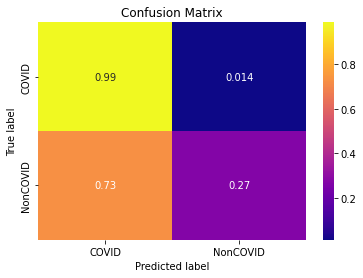

In [25]:
print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

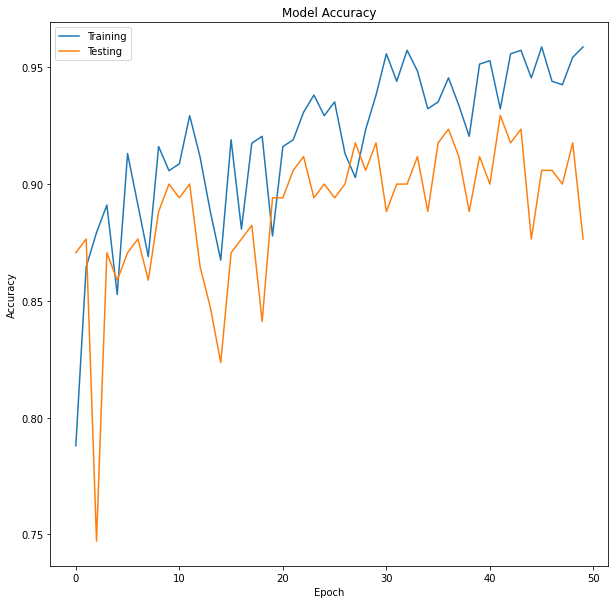

In [28]:
plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_accuracy.png')
plt.show()

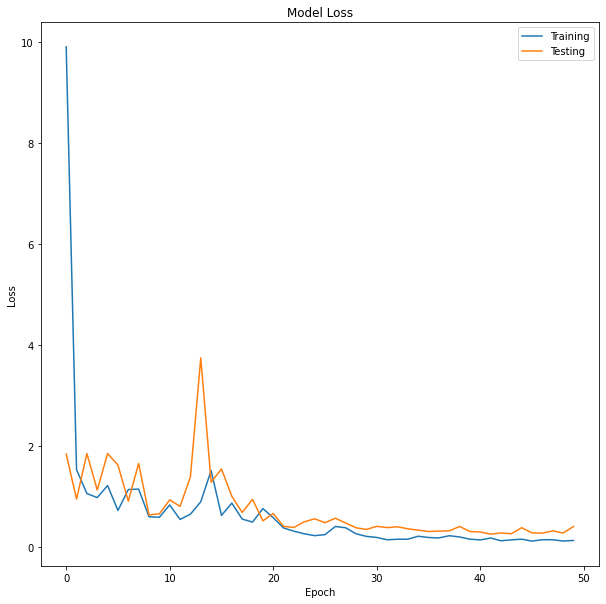

In [29]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_loss.png')
plt.show()

In [30]:
from keras.models import Model,load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [31]:
img=image.load_img('/content/gdrive/MyDrive/covid-19/chest_xray/chest_xray/val/covid/person1946_bacteria_4875.jpeg',target_size=(224,224,3))

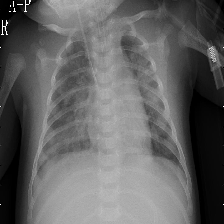

In [32]:
img

In [33]:
img_array=image.img_to_array(img)

In [34]:
img_array=img_array/255

In [35]:
img_array=img_array.reshape((1,)+img_array.shape)

In [36]:
img_array.shape

(1, 224, 224, 3)

In [37]:
XRAY_pred=model.predict(img_array)

In [38]:
XRAY_pred

array([[9.999999e-01, 8.411021e-08]], dtype=float32)

In [39]:
image_type_class = XRAY_pred.argmax()

In [40]:
image_type_class

0

In [41]:
if (image_type_class==0):
    print('COVID XRAY')
else:
    print('NORMAL XRAY')

COVID XRAY


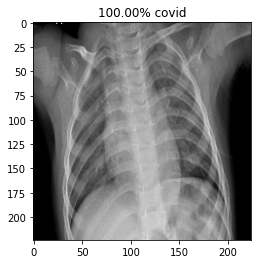

In [42]:
for index,probability in enumerate(XRAY_pred):
  if probability[1] > 0.5:
    plt.title('%.2f' % (probability[1]*100) + '% non-covid')
  else:
    plt.title('%.2f' % ((1-probability[1])*100) + '% covid')
  plt.imshow(X_test[index])
  plt.show()


In [43]:
model.load_weights("xception_chest.h5")
score = model.evaluate(X_train,y_train,verbose=1)
print('Train Loss:', score[0])
print('Train accuracy:', score[1]*100)

22/22 [==============================] - 3s 76ms/step - loss: 0.1872 - accuracy: 0.9293
Train Loss: 0.1872180998325348
Train accuracy: 92.93078184127808
